In [2]:
# Cell 1: Общее конфигурирование
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device("cuda")
print('Device:', device)
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "InvertedDoublePendulum"
ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"
# ENV_ID = "InvertedPendulum-v5"
# ENV_ID = "Pendulum-v1"


Device: cuda


# Создание среды

In [3]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


2025-08-23 13:44:11,352 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [5]:

check_env_specs(env)
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor, is_acts_discrete
from torchrl.modules import ValueOperator
# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]
# если действия непрерывные, то число выходов нейросети нужно удвоить:
coef = 1 if is_acts_discrete(env.action_spec) else 2
mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = act_dim * coef,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)
actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)
mlp_cfg.out_dim = 1
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
actor.to(device), critic.to(device)
obs_dim, act_dim

2025-08-23 13:45:37,967 [torchrl][INFO]    check_env_specs succeeded! [END]


(11, 1)

# Collector

In [8]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 100_000

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [9]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)

# Generate Paths

In [10]:
from agentslab.utils.misc import RunPaths, generate_paths

paths = generate_paths(ROOT, ALGO_NAME, ENV_NAME)
print(paths)

RunPaths(root=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab'), run_dir=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621'), ckpt_dir=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/checkpoints'), csv_train=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/csv_logs/train.csv'), csv_eval=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/csv_logs/eval.csv'), tb_train=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/tb_logs/train'), tb_eval=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/tb_logs/eval'), meta_yaml=WindowsPath('C:/Users/werna/Documents/GitHub/AgentsLab/runs/ppo_InvertedDoublePendulum_20250823_134621/meta_info.yaml'))


# Loggers

In [11]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(paths.csv_train)
csv_logger_eval = CSVLogger(paths.csv_eval)
tb_logger_train = TBLogger(paths.tb_train)
tb_logger_eval = TBLogger(paths.tb_eval)

# Checkpointers

In [12]:
from agentslab.utils.checkpointers import CheckpointManager

statefuls = {
    "policy": actor,                # nn.Module
    "optimizer": optim,             # torch.optim.Optimizer
    "scheduler": scheduler,         # lr scheduler
    "replay": replay_buffer,        # TorchRL ReplayBuffer (если используете)
}

chkptr = CheckpointManager(
    ckpt_dir=paths.ckpt_dir,               # .../runs/<run_name>/checkpoints
    statefuls=statefuls,
    meta={"algo": ALGO_NAME, "env": ENV_ID},
    best_metric_key="return_mean",    # по какой метрике выбирать best
    mode="max",                            # "min" для ошибок/лоссов
    max_to_keep=5,
)

# Training Loop

In [25]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy

max_grad_norm = 1.0
num_epochs = 10
sub_batch_size = 64
eval_every = 5

log_dict = dict()
passed_frames = 0

with progress_bar(total_frames, desc="PPO") as pbar:
    # --------------------------------------------------------------
    # Итерируемся по коллекторам, пока не наберём нужное число шагов
    for i, tensordict_data in enumerate(collector):
        # Учимся на партии данных
        for _ in range(num_epochs):
            # Advantage для PPO пересчитываем на каждом проходе
            advantage_module(tensordict_data)
            data_view = tensordict_data.reshape(-1)
            replay_buffer.extend(data_view.cpu())
            for _ in range(frames_per_batch // sub_batch_size):
                subdata = replay_buffer.sample(sub_batch_size)
                loss_vals = loss_module(subdata.to(device))
                loss_value = (
                      loss_vals["loss_objective"] 
                    + loss_vals["loss_critic"] 
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
                optim.step()
                optim.zero_grad()
        scheduler.step()            # Шаг LR-планировщика

        # --------------------------------------------------------------

        # Извлекаем метрики
        batch_frames = int(tensordict_data.get(("next", "reward")).numel())
        passed_frames = min(passed_frames + batch_frames, total_frames)
        log_dict['step'] = passed_frames
        log_dict["reward"] = tensordict_data["next", "reward"].mean().item()
        log_dict["step_count"] = tensordict_data["step_count"].max().item()
        log_dict["lr"] = optim.param_groups[0]["lr"]
        
        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict['step'])    # TensorBoard

        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"avg_reward": f"{log_dict["reward"]: .4f}",
             "max_step": int(log_dict["step_count"]),
             "lr": f"{log_dict["lr"]: .4e}"},
            refresh=False
        )

        # корректное число фреймов в партии

        if batch_frames > 0:
            remaining = pbar.total - pbar.n
            pbar.update(min(batch_frames, remaining))

        # -----------------------------------------------------------
        # Оценка после каждых eval_every партий
        if (i + 1) % eval_every == 0:
            eval_results = eval_policy(env, actor, episodes=5, progress=False)
            # pbar.write не ломает отрисовку прогресс-бара
            pbar.write(
                f'eval: avg reward = {eval_results["return_mean"]}, '
                f'max episode lengh = {eval_results["max_episode_lengh"]}'
            )
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard
            chkptr.save(step=log_dict['step'], metrics=eval_results, make_step_snapshot=True)
        

PPO:   0%|          | 0.00/100k [00:00<?, ?frames/s]

eval: avg reward = 150.06659240722655, max episode lengh = 18
eval: avg reward = 267.5869934082031, max episode lengh = 36
eval: avg reward = 340.4028259277344, max episode lengh = 50
eval: avg reward = 491.96002807617185, max episode lengh = 82
eval: avg reward = 514.2395263671875, max episode lengh = 68
eval: avg reward = 600.2825561523438, max episode lengh = 70
eval: avg reward = 654.427197265625, max episode lengh = 109
eval: avg reward = 1300.3422607421876, max episode lengh = 219
eval: avg reward = 2253.1989013671873, max episode lengh = 320
eval: avg reward = 3685.455859375, max episode lengh = 530
eval: avg reward = 3032.7158935546877, max episode lengh = 546
eval: avg reward = 6880.765234375, max episode lengh = 999
eval: avg reward = 9335.2783203125, max episode lengh = 999
eval: avg reward = 9330.808984375, max episode lengh = 999
eval: avg reward = 9332.6279296875, max episode lengh = 999
eval: avg reward = 9330.7291015625, max episode lengh = 999
eval: avg reward = 6365.2

# Graphs

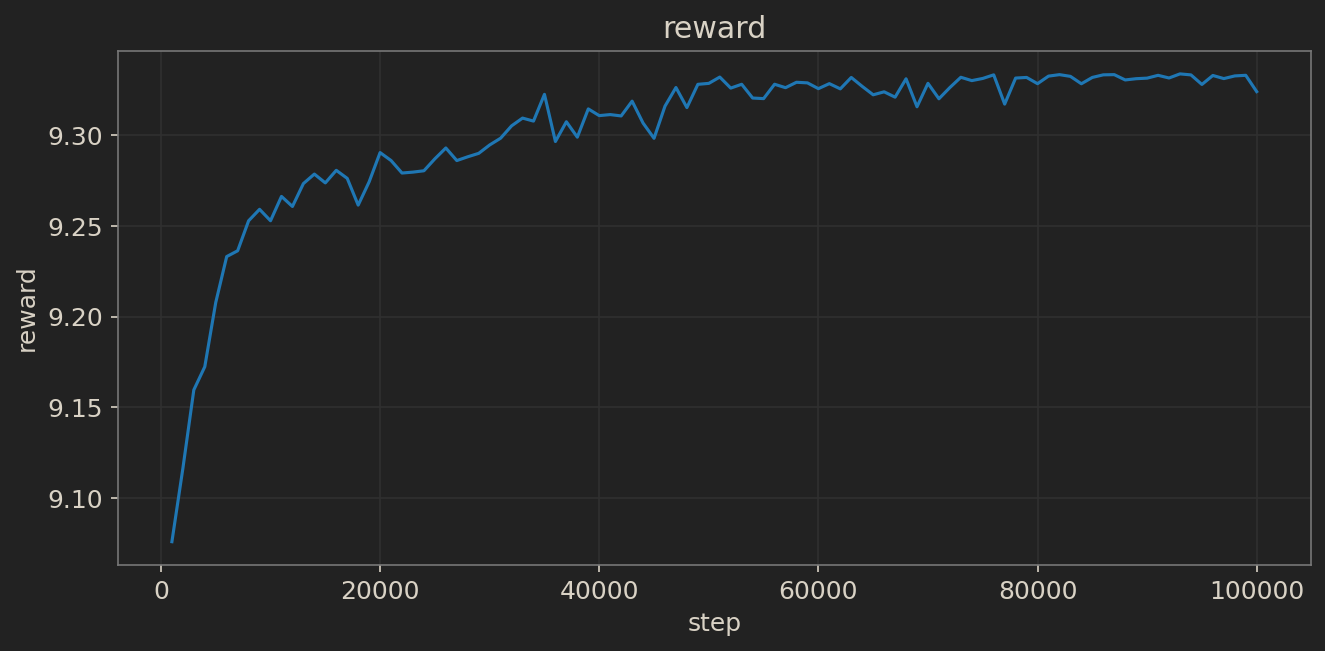

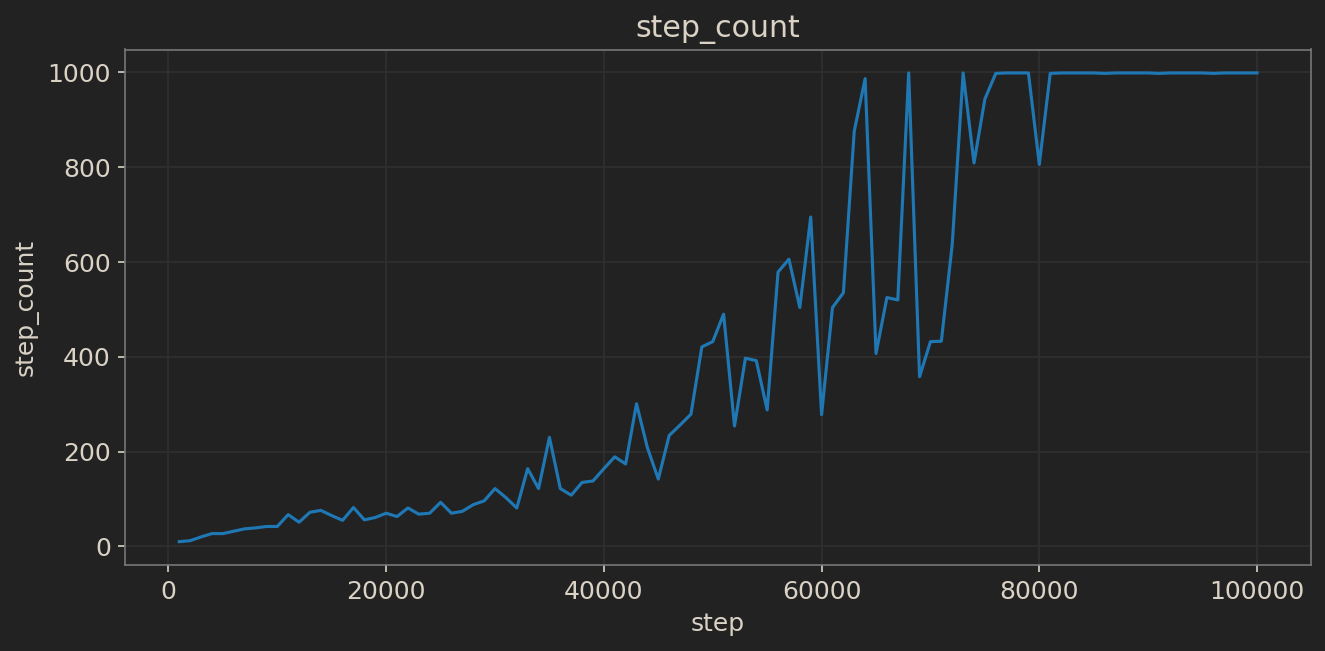

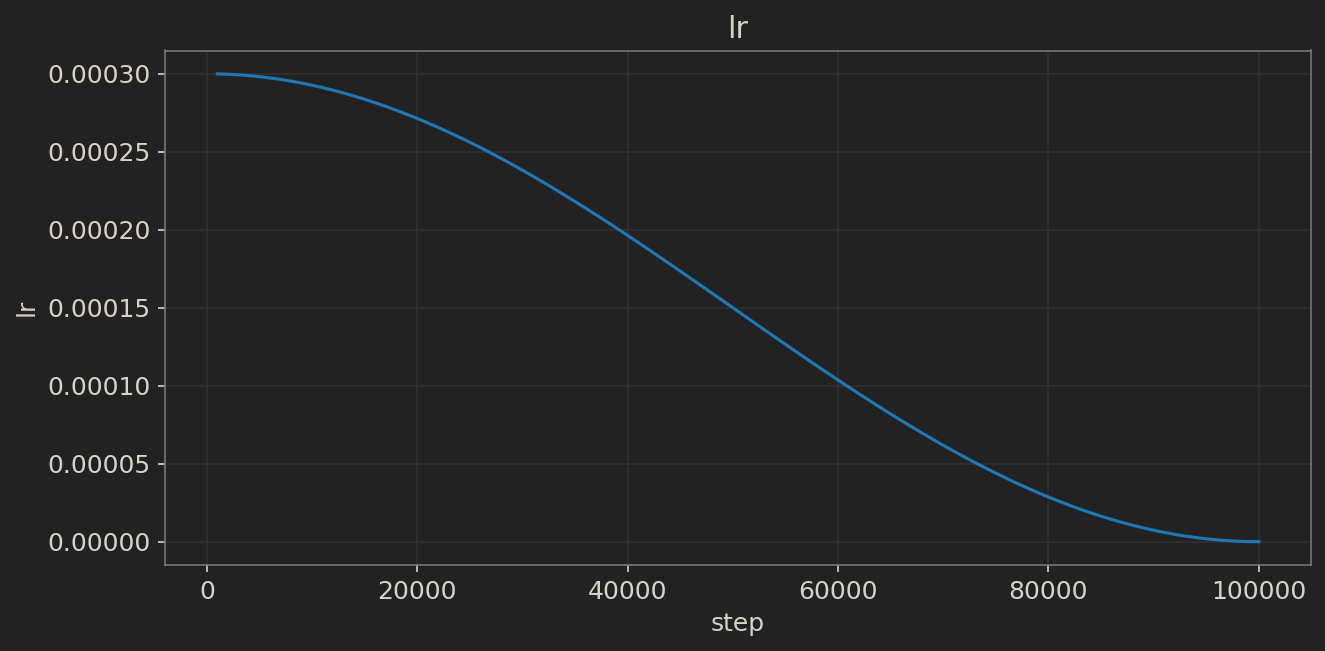

In [26]:
# Чтение последнего train.csv и построение графиков по каждой метрике
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ordevoir-dark")

csv_path = paths.csv_train  # объект paths из вашего кода (RunPaths.csv_train)

# Проверим наличие файла
if not csv_path.exists():
    raise FileNotFoundError(f"train.csv не найден по пути: {csv_path}")

# Читаем CSV (без агрессивных эвристик типов, чтобы избежать предупреждений)
df = pd.read_csv(csv_path, low_memory=False)

# Определим ось X: предпочитаем 'step', затем 'global_step', 'iteration', 'epoch'
x_candidates = [c for c in ["step", "global_step", "iteration", "epoch"] if c in df.columns]
x_col = x_candidates[0] if x_candidates else None

# Выбираем числовые столбцы, исключая ось X
num_cols = df.select_dtypes(include="number").columns.tolist()
if x_col in num_cols:
    num_cols.remove(x_col)

if not num_cols:
    raise ValueError(
        "В train.csv не найдено числовых метрик для построения графиков."
    )

# Строим отдельную диаграмму для каждой метрики
for col in num_cols:
    plt.figure(figsize=(9, 4.5))
    if x_col is not None:
        plt.plot(df[x_col], df[col])
        plt.xlabel(x_col)
    else:
        plt.plot(range(len(df)), df[col])
        plt.xlabel("index")
    plt.ylabel(col)
    plt.title(f"{col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Evaluating

In [27]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=10)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

{'return_mean': 7725.320928955078,
 'return_sum': 77253.20928955078,
 'max_episode_lengh': 999,
 'num_episodes': 10}

In [28]:
env.close()

In [13]:
chkptr.load("best", strict=False, map_location=device   )

FileNotFoundError: Чекпоинт не найден: C:\Users\werna\Documents\GitHub\AgentsLab\runs\ppo_InvertedDoublePendulum_20250823_134621\checkpoints\best.pt